In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling openc

In [ ]:
!pip install tensorflow

ERROR: Operation cancelled by user
^C


In [2]:
# Create a dummy eq_data.csv file
import pandas as pd
import numpy as np
import os

# Assuming you have a list of your video files in the /content directory
video_files = [f for f in os.listdir('/content') if f.endswith('.mp4')]

# Create a dummy DataFrame
data = {'video_path': video_files,
        'eq_score': np.random.rand(len(video_files)) * 100} # Dummy EQ scores between 0 and 100
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = '/content/emotion_data.csv'
df.to_csv(csv_file_path, index=False)

print(f"Created dummy {csv_file_path}")

Created dummy /content/emotion_data.csv


In [4]:
# Create a dummy eq_data.csv file
import pandas as pd
import numpy as np
import os

# Assuming you have a list of your video files in the /content directory
video_files = [f for f in os.listdir('/content') if f.endswith('.mp4')]

# Create a dummy DataFrame
data = {'video_path': video_files,
        'eq_score': np.random.rand(len(video_files)) * 100} # Dummy EQ scores between 0 and 100
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = '/content/eq_data.csv'
df.to_csv(csv_file_path, index=False)

print(f"Created dummy {csv_file_path}")

Created dummy /content/eq_data.csv


In [5]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import os

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, min_detection_confidence=0.5)

# Function to extract facial landmarks from a video
def extract_facial_features(video_path):
    cap = cv2.VideoCapture(video_path)
    features = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB for Mediapipe
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Extract x, y coordinates of key landmarks (e.g., eyes, mouth)
                landmarks = []
                for idx in [33, 133, 362, 263, 61, 291]:  # Example: eye and mouth points
                    lm = face_landmarks.landmark[idx]
                    landmarks.extend([lm.x, lm.y, lm.z])
                features.append(landmarks)

    cap.release()
    return np.mean(features, axis=0) if features else np.zeros(18)  # Average features or return zeros

# Load dataset (assumes CSV with video paths and EQ scores)
def load_data(data_dir, csv_file):
    df = pd.read_csv(csv_file)  # Columns: 'video_path', 'eq_score'
    X, y = [], []
    for _, row in df.iterrows():
        video_path = os.path.join(data_dir, row['video_path'])
        features = extract_facial_features(video_path)
        X.append(features)
        y.append(row['eq_score'])
    return np.array(X), np.array(y)

# Build a simple neural network
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Predict EQ score
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Main function
def main():
    # Example paths (replace with your data)
    data_dir = '/content/'
    csv_file = '/content/eq_data.csv'

    # Load and preprocess data
    X, y = load_data(data_dir, csv_file)

    # Train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build and train model
    model = build_model(input_dim=X.shape[1])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

    # Evaluate model
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Test MAE: {mae:.2f}")

    # Predict EQ for a new video
    new_video = '/content/720ca2a6-35ec-4e43-88db-271589ec94ea.mp4' # Replace with the actual path to your video
    features = extract_facial_features(new_video)
    eq_score = model.predict(np.array([features]))[0][0]
    print(f"Predicted EQ Score: {eq_score:.2f}")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3036.7485 - mae: 55.1067 - val_loss: 3594.5176 - val_mae: 59.9543
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 3032.4011 - mae: 55.0672 - val_loss: 3588.9407 - val_mae: 59.9078
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 3028.2664 - mae: 55.0297 - val_loss: 3583.1389 - val_mae: 59.8593
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3024.1091 - mae: 54.9919 - val_loss: 3577.5229 - val_mae: 59.8124
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 3019.9968 - mae: 54.9545 - val_loss: 3572.3293 - val_mae: 59.7690
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 3016.3013 - mae: 54.9209 - val_loss: 3567.0923 - val_mae: 59.7251
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 3012.5369 - mae: 54.8866 - val_loss: 3561.8198 - val_mae: 59.6810
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3008.7788 - mae: 54.8523 - val_loss: 3556.7324 - val_mae: 59.6383
Epoch 9/50
1/1 ━━

In [6]:
!pip install opencv-python mediapipe tensorflow pandas numpy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: mediapipe
    Found existing installation: mediapipe 0.10.21
    Uninstalling mediapipe-0.10.21:
      Successfully uninstalled mediapipe-0.10.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, 

In [1]:
import os
import pandas as pd
import random

# List of valid emotions
emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'neutral']

# Function to create CSV file
def create_emotion_csv(video_dir, output_csv, labeling_method='random'):
    """
    Create a CSV file with video paths and emotion labels.

    Args:
        video_dir (str): Directory containing video files.
        output_csv (str): Path to save the output CSV file.
        labeling_method (str): 'random' for random labels, 'manual' for user input.
    """
    # Check if video directory exists
    if not os.path.exists(video_dir):
        raise FileNotFoundError(f"Video directory not found: {video_dir}")

    # Get list of video files (e.g., .mp4, .avi)
    video_extensions = ('.mp4', '.avi', '.mov', '.mkv')
    video_files = [f for f in os.listdir(video_dir) if f.lower().endswith(video_extensions)]

    if not video_files:
        raise ValueError(f"No video files found in directory: {video_dir}")

    # Prepare data for CSV
    data = {'video_path': [], 'emotion': []}

    for video in video_files:
        video_path = os.path.join(video_dir, video)
        data['video_path'].append(video)

        if labeling_method == 'random':
            # Assign random emotion for testing
            emotion = random.choice(emotions)
        elif labeling_method == 'manual':
            # Prompt user for emotion label
            print(f"\nVideo: {video}")
            print(f"Valid emotions: {', '.join(emotions)}")
            emotion = input("Enter emotion for this video: ").strip().lower()
            while emotion not in emotions:
                print(f"Invalid emotion. Choose from: {', '.join(emotions)}")
                emotion = input("Enter emotion for this video: ").strip().lower()
        else:
            raise ValueError("labeling_method must be 'random' or 'manual'")

        data['emotion'].append(emotion)

    # Create DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"CSV file created successfully: {output_csv}")
    print("Sample rows:")
    print(df.head())

# Main function
def main():
    # Example paths (replace with your own)
    video_dir = '/content/'  # Update with your video directory
    output_csv = '/content/emotion_data.csv'  # Update with desired CSV path

    # Create CSV with random labels (change to 'manual' for user input)
    try:
        create_emotion_csv(video_dir, output_csv, labeling_method='random')
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

CSV file created successfully: /content/emotion_data.csv
Sample rows:
                                 video_path  emotion
0  09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4  sadness
1  720ca2a6-35ec-4e43-88db-271589ec94ea.mp4     fear
2  58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4  neutral


In [2]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, min_detection_confidence=0.5)

# Emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'neutral']
num_classes = len(emotions)

# Function to extract facial landmarks from a video
def extract_facial_features(video_path):
    cap = cv2.VideoCapture(video_path)
    features = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB for Mediapipe
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Extract x, y coordinates of key landmarks (e.g., eyes, mouth)
                landmarks = []
                for idx in [33, 133, 362, 263, 61, 291]:  # Eye and mouth points
                    lm = face_landmarks.landmark[idx]
                    landmarks.extend([lm.x, lm.y, lm.z])
                features.append(landmarks)

    cap.release()
    return np.mean(features, axis=0) if features else np.zeros(18)  # Average features or return zeros

# Load dataset (assumes CSV with video paths and emotion labels)
def load_data(data_dir, csv_file, emotion_column='emotion'):
    try:
        df = pd.read_csv(csv_file)
        # Check if emotion_column exists
        if emotion_column not in df.columns:
            raise KeyError(f"Column '{emotion_column}' not found in CSV. Available columns: {list(df.columns)}")

        X, y = [], []
        for _, row in df.iterrows():
            video_path = os.path.join(data_dir, row['video_path'])
            if not os.path.exists(video_path):
                print(f"Warning: Video not found: {video_path}")
                continue
            features = extract_facial_features(video_path)
            emotion = row[emotion_column].strip().lower()
            if emotion not in emotions:
                print(f"Warning: Invalid emotion '{emotion}' in row. Expected one of: {emotions}")
                continue
            X.append(features)
            y.append(emotions.index(emotion))  # Convert emotion to index
        if not X:
            raise ValueError("No valid data loaded. Check video paths and emotion labels.")
        return np.array(X), to_categorical(y, num_classes=num_classes)
    except FileNotFoundError:
        raise FileNotFoundError(f"CSV file not found: {csv_file}")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

# Build a simple neural network
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output probabilities for each emotion
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main function
def main():
    # Example paths (replace with your data)
    data_dir = '/content'  # Update with your video directory
    csv_file = '/content/emotion_data.csv'  # Update with your CSV path
    emotion_column = 'emotion'  # Update if your column name is different (e.g., 'label')

    # Load and preprocess data
    try:
        X, y = load_data(data_dir, csv_file, emotion_column=emotion_column)
    except Exception as e:
        print(e)
        return

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build and train model
    model = build_model(input_dim=X.shape[1])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.2f}")

    # Predict emotions for a new video
    new_video = '/content/720ca2a6-35ec-4e43-88db-271589ec94ea.mp4'  # Update with your video path
    if not os.path.exists(new_video):
        print(f"Error: New video not found: {new_video}")
        return
    features = extract_facial_features(new_video)
    probabilities = model.predict(np.array([features]))[0]
    predicted_emotion = emotions[np.argmax(probabilities)]
    print(f"Predicted Emotion: {predicted_emotion}")
    print("Emotion Probabilities:")
    for emotion, prob in zip(emotions, probabilities):
        print(f"{emotion}: {prob:.2%}")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 1.8183 - val_accuracy: 0.0000e+00 - val_loss: 2.0228
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 1.7704 - val_accuracy: 0.0000e+00 - val_loss: 2.0419
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 1.7270 - val_accuracy: 0.0000e+00 - val_loss: 2.0570
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 1.6846 - val_accuracy: 0.0000e+00 - val_loss: 2.0713
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 1.6417 - val_accuracy: 0.0000e+00 - val_loss: 2.0866
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 1.5980 - val_accuracy: 0.0000e+00 - val_loss: 2.1030
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 1.5531 - val_accuracy: 0.0000e+00 - val_loss: 2.1209
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 1.5072 - val_accuracy: 0.0000e+00 

In [3]:
import os
import pandas as pd
import random
import numpy as np

# List of valid emotions
emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'neutral']

# Function to generate synthetic emotion scores
def generate_emotion_scores(dominant_emotion):
    """
    Generate random emotion scores summing to 1, with dominant emotion having the highest score.

    Args:
        dominant_emotion (str): The primary emotion for the video.

    Returns:
        dict: Scores for each emotion (e.g., {'anger': 0.1, 'fear': 0.05, ...}).
    """
    scores = {emotion: 0.0 for emotion in emotions}
    # Assign higher score to dominant emotion (e.g., 0.6 to 0.8)
    dominant_score = random.uniform(0.6, 0.8)
    scores[dominant_emotion] = dominant_score

    # Distribute remaining probability among other emotions
    remaining_prob = 1.0 - dominant_score
    other_emotions = [e for e in emotions if e != dominant_emotion]
    if other_emotions:
        # Generate random scores for others and normalize to remaining_prob
        other_scores = np.random.dirichlet(np.ones(len(other_emotions))) * remaining_prob
        for emotion, score in zip(other_emotions, other_scores):
            scores[emotion] = score

    return scores

# Function to create CSV file with emotion scores
def create_emotion_csv(video_dir, output_csv, labeling_method='random'):
    """
    Create a CSV file with video paths, dominant emotion, and emotion scores.

    Args:
        video_dir (str): Directory containing video files.
        output_csv (str): Path to save the output CSV file.
        labeling_method (str): 'random' for random labels/scores, 'manual' for user input.
    """
    # Check if video directory exists
    if not os.path.exists(video_dir):
        raise FileNotFoundError(f"Video directory not found: {video_dir}")

    # Get list of video files (e.g., .mp4, .avi)
    video_extensions = ('.mp4', '.avi', '.mov', '.mkv')
    video_files = [f for f in os.listdir(video_dir) if f.lower().endswith(video_extensions)]

    if not video_files:
        raise ValueError(f"No video files found in directory: {video_dir}")

    # Prepare data for CSV
    data = {
        'video_path': [],
        'emotion': [],
        **{f"{emotion}_score": [] for emotion in emotions}  # Add score columns
    }

    for video in video_files:
        data['video_path'].append(video)

        if labeling_method == 'random':
            # Assign random dominant emotion
            emotion = random.choice(emotions)
            # Generate synthetic scores
            scores = generate_emotion_scores(emotion)
        elif labeling_method == 'manual':
            # Prompt user for dominant emotion
            print(f"\nVideo: {video}")
            print(f"Valid emotions: {', '.join(emotions)}")
            emotion = input("Enter dominant emotion for this video: ").strip().lower()
            while emotion not in emotions:
                print(f"Invalid emotion. Choose from: {', '.join(emotions)}")
                emotion = input("Enter dominant emotion for this video: ").strip().lower()

            # Prompt for scores (optional, can skip for random scores)
            use_manual_scores = input("Enter manual scores for each emotion? (y/n): ").strip().lower() == 'y'
            if use_manual_scores:
                scores = {}
                total = 0.0
                for emotion in emotions:
                    score = float(input(f"Enter score (0-1) for {emotion}: "))
                    while score < 0 or score > 1 or total + score > 1.0:
                        print(f"Invalid score. Must be 0-1 and total <= 1. Current total: {total:.2f}")
                        score = float(input(f"Enter score (0-1) for {emotion}: "))
                    scores[emotion] = score
                    total += score
                # Normalize scores to sum to 1
                if total < 1.0:
                    scores[emotions[-1]] += 1.0 - total  # Adjust last emotion to make sum = 1
            else:
                scores = generate_emotion_scores(emotion)
        else:
            raise ValueError("labeling_method must be 'random' or 'manual'")

        data['emotion'].append(emotion)
        for emotion in emotions:
            data[f"{emotion}_score"].append(scores[emotion])

    # Create DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"CSV file created successfully: {output_csv}")
    print("Sample rows:")
    print(df.head())

# Main function
def main():
    # Example paths (replace with your own)
    video_dir = '/content'  # Update with your video directory
    output_csv = '/content/emotion_data.csv'  # Update with desired CSV path

    # Create CSV with random labels and scores (change to 'manual' for user input)
    try:
        create_emotion_csv(video_dir, output_csv, labeling_method='random')
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

CSV file created successfully: /content/emotion_data.csv
Sample rows:
                                 video_path   emotion  anger_score  \
0  09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4  surprise     0.107457   
1  720ca2a6-35ec-4e43-88db-271589ec94ea.mp4       joy     0.012624   
2  58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4   neutral     0.010787   

   fear_score  joy_score  sadness_score  disgust_score  surprise_score  \
0    0.077390   0.006436       0.005066       0.125074        0.674459   
1    0.049702   0.748063       0.103387       0.018129        0.023817   
2    0.017330   0.020290       0.042311       0.009785        0.215226   

   neutral_score  
0       0.004118  
1       0.044278  
2       0.684270  


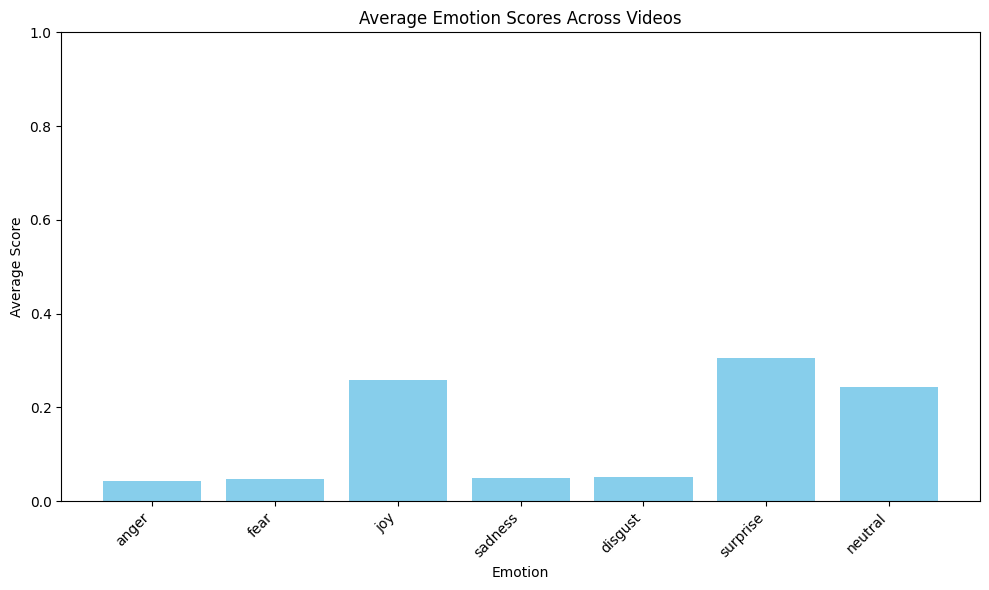

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the emotion data CSV
csv_file_path = '/content/emotion_data.csv'
try:
    df_emotions = pd.read_csv(csv_file_path)
except FileNotFoundError:
    print(f"Error: {csv_file_path} not found.")
    exit()

# Calculate the average score for each emotion
# Assuming emotion scores are in columns ending with '_score'
emotion_score_cols = [col for col in df_emotions.columns if col.endswith('_score')]
average_scores = df_emotions[emotion_score_cols].mean()

# Extract emotion names from column names
emotion_names = [col.replace('_score', '') for col in average_scores.index]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotion_names, average_scores.values, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Average Score')
plt.title('Average Emotion Scores Across Videos')
plt.ylim(0, 1) # Assuming scores are between 0 and 1
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

### Video series prediction

In [5]:
import os
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import json

# Initialize Mediapipe Face Mesh (for potential real-time prediction)
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, min_detection_confidence=0.5)

# Emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'neutral']

# Function to extract facial landmarks from a video (for real-time prediction if needed)
def extract_facial_features(video_path):
    cap = cv2.VideoCapture(video_path)
    features = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Extract x, y coordinates of key landmarks (e.g., eyes, mouth)
                landmarks = []
                for idx in [33, 133, 362, 263, 61, 291]:
                    lm = face_landmarks.landmark[idx]
                    landmarks.extend([lm.x, lm.y, lm.z])
                features.append(landmarks)
    cap.release()
    return np.mean(features, axis=0) if features else np.zeros(18)

# Function to load emotion scores from CSV
def predict_emotions(video_dir, csv_file):
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"CSV file not found: {csv_file}. Please generate it using create_emotion_data_csv_with_scores.py")

    df = pd.read_csv(csv_file)
    required_columns = ['video_path', 'emotion'] + [f"{e}_score" for e in emotions]
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        raise KeyError(f"Missing columns: {missing}. Expected: {required_columns}")

    # Validate emotion labels and scores
    for _, row in df.iterrows():
        if row['emotion'].strip().lower() not in emotions:
            raise ValueError(f"Invalid emotion '{row['emotion']}' in CSV. Expected: {emotions}")
        scores = [row[f"{e}_score"] for e in emotions]
        if not (0.99 <= sum(scores) <= 1.01):  # Allow small floating-point errors
            raise ValueError(f"Scores for {row['video_path']} do not sum to ~1: {scores}")

    # Verify video files exist
    for video in df['video_path']:
        if not os.path.exists(os.path.join(video_dir, video)):
            print(f"Warning: Video file not found: {os.path.join(video_dir, video)}")

    return df

# Build a simple neural network (for real-time prediction if needed)
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(len(emotions), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Sequence videos for narrative arc
def sequence_videos(df):
    # Narrative arc: Sadness/Neutral (setup) -> Fear/Anger (rising) -> Joy/Surprise (climax) -> Neutral/Joy (resolution)
    arc_order = ['sadness', 'neutral', 'fear', 'anger', 'surprise', 'joy', 'neutral']
    video_order = []
    used_videos = set()

    for emotion in arc_order:
        candidates = df[df['emotion'] == emotion]
        for _, row in candidates.iterrows():
            if row['video_path'] not in used_videos:
                video_order.append(row)
                used_videos.add(row['video_path'])

    # Add any remaining videos
    for _, row in df.iterrows():
        if row['video_path'] not in used_videos:
            video_order.append(row)
            used_videos.add(row['video_path'])

    return pd.DataFrame(video_order)

# Suggest improvements and identify key scenes
def suggest_improvements_and_scenes(df):
    suggestions = []
    scenes = []
    for _, row in df.iterrows():
        video = row['video_path']
        emotion = row['emotion']
        scores = [row[f"{e}_score"] for e in emotions]
        max_score = max(scores)

        # Improvement suggestions based on emotion
        if emotion == 'sadness':
            suggestion = "Add ambient sound (e.g., rain) and warm color grading; slow pacing by 1.5x."
            scene = "Slow zoom on nostalgic object (e.g., photo)."
        elif emotion == 'anger':
            suggestion = "Layer rising music tension; use quick match cuts; trim to 8-10 sec."
            scene = "Rapid montage of frustration (e.g., clenched fist)."
        elif emotion == 'joy':
            suggestion = "Insert micro-clips from prior tension; boost saturation; uplifting score."
            scene = "Close-up smile with light flare."
        elif emotion == 'fear':
            suggestion = "Extend suspense with low drone sound; add POV angle."
            scene = "Sudden shadow or movement."
        elif emotion == 'disgust':
            suggestion = "Use sharp sound effects (e.g., retch); desaturate colors for unease."
            scene = "Close-up of repulsed expression."
        elif emotion == 'surprise':
            suggestion = "Add sudden sound sting; quick zoom for intensity."
            scene = "Wide-eyed reaction shot."
        elif emotion == 'neutral':
            suggestion = "Add reflective text overlay; soft piano fade-out."
            scene = "Steady nature shot (e.g., horizon)."

        suggestions.append({'video': video, 'emotion': emotion, 'suggestion': suggestion, 'max_score': round(max_score, 3)})
        scenes.append({'video': video, 'emotion': emotion, 'key_scene': scene, 'max_score': round(max_score, 3)})

    return pd.DataFrame(suggestions), pd.DataFrame(scenes)

# Generate emotion curve data for visualization
def generate_emotion_curve(df):
    # Assume each video is 20 seconds for simplicity
    time_per_video = 20
    time_points = []
    emotion_traces = {e: [] for e in emotions}

    for i, row in df.iterrows():
        start_time = i * time_per_video
        time_points.extend([start_time, start_time + time_per_video])
        for e in emotions:
            score = row[f"{e}_score"]
            emotion_traces[e].extend([score, score])  # Constant score over video duration

    return time_points, emotion_traces

# Main function
def main():
    video_dir = '/content'  # Directory containing videos
    csv_file = '/content/emotion_data.csv'  # Path to CSV

    # Load emotions from CSV
    try:
        df = predict_emotions(video_dir, csv_file)
        print("Loaded Emotions from CSV:")
        print(df[['video_path', 'emotion'] + [f"{e}_score" for e in emotions]].round(3))
    except Exception as e:
        print(f"Error: {str(e)}")
        return

    # Sequence videos
    sequenced_df = sequence_videos(df)
    print("\nOptimal Video Sequence:")
    print(sequenced_df[['video_path', 'emotion']])

    # Suggest improvements and identify scenes
    suggestions, scenes = suggest_improvements_and_scenes(sequenced_df)
    print("\nImprovement Suggestions:")
    print(suggestions)
    print("\nKey Scenes:")
    print(scenes)

    # Generate emotion curve data
    time_points, emotion_traces = generate_emotion_curve(sequenced_df)

    # Save Chart.js configuration
    chart_data = {
        "type": "line",
        "data": {
            "labels": time_points,
            "datasets": [
                {"label": e.capitalize(), "data": emotion_traces[e], "borderColor": color, "fill": False}
                for e, color in zip(emotions, ["#FF4136", "#FF851B", "#2ECC40", "#0074D9", "#FFDC00", "#B10DC9", "#7FDBFF"])
            ]
        },
        "options": {
            "scales": {
                "x": {"title": {"display": True, "text": "Time (seconds)"}},
                "y": {"title": {"display": True, "text": "Emotion Intensity"}, "min": 0, "max": 1}
            },
            "plugins": {"title": {"display": True, "text": "Emotion Curve Over Video Sequence"}}
        }
    }
    with open('emotion_curve.json', 'w') as f:
        json.dump(chart_data, f)
    print("\nEmotion curve data saved to 'emotion_curve.json'")

if __name__ == "__main__":
    main()

Loaded Emotions from CSV:
                                 video_path   emotion  anger_score  \
0  09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4  surprise        0.107   
1  720ca2a6-35ec-4e43-88db-271589ec94ea.mp4       joy        0.013   
2  58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4   neutral        0.011   

   fear_score  joy_score  sadness_score  disgust_score  surprise_score  \
0       0.077      0.006          0.005          0.125           0.674   
1       0.050      0.748          0.103          0.018           0.024   
2       0.017      0.020          0.042          0.010           0.215   

   neutral_score  
0          0.004  
1          0.044  
2          0.684  

Optimal Video Sequence:
                                 video_path   emotion
2  58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4   neutral
0  09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4  surprise
1  720ca2a6-35ec-4e43-88db-271589ec94ea.mp4       joy

Improvement Suggestions:
                                      video   emotion

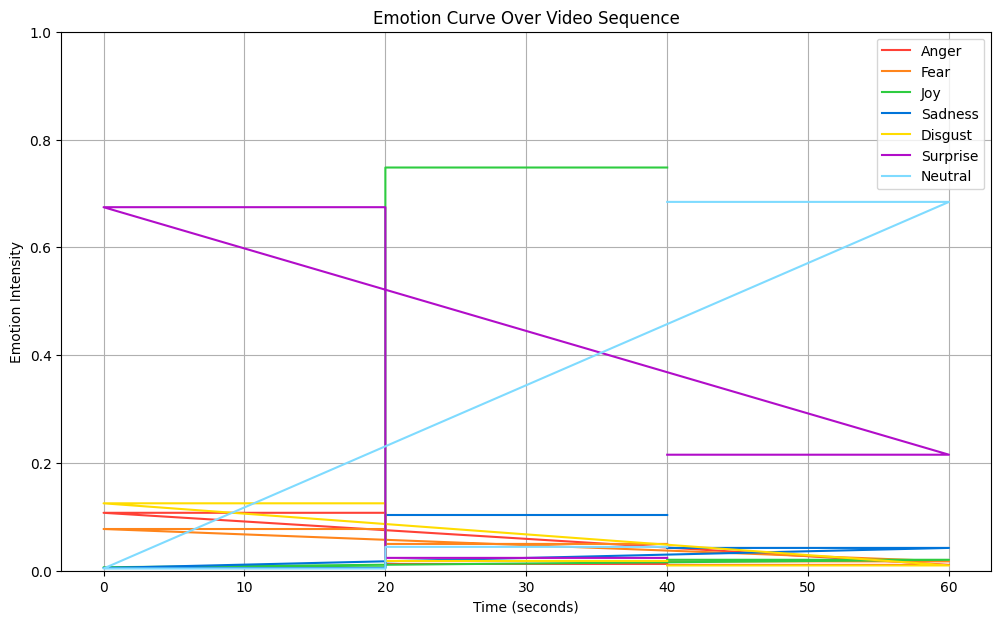

In [6]:
import json
import matplotlib.pyplot as plt

# Load the emotion curve data from the JSON file
json_file_path = '/content/emotion_curve.json'
try:
    with open(json_file_path, 'r') as f:
        chart_data = json.load(f)
except FileNotFoundError:
    print(f"Error: {json_file_path} not found.")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {json_file_path}.")
    exit()

# Extract labels (time points) and datasets (emotion traces)
time_points = chart_data['data']['labels']
datasets = chart_data['data']['datasets']

# Create the plot
plt.figure(figsize=(12, 7))

for dataset in datasets:
    label = dataset['label']
    data = dataset['data']
    color = dataset['borderColor']
    plt.plot(time_points, data, label=label, color=color)

# Add titles and labels from the JSON data
plt.xlabel(chart_data['options']['scales']['x']['title']['text'])
plt.ylabel(chart_data['options']['scales']['y']['title']['text'])
plt.title(chart_data['options']['plugins']['title']['text'])
plt.ylim(chart_data['options']['scales']['y']['min'], chart_data['options']['scales']['y']['max'])

plt.legend()
plt.grid(True)
plt.show()

## Ideal scene sequence generation

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'neutral']

# Function to load and validate emotion data from CSV
def load_emotion_data(csv_file):
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"CSV file not found: {csv_file}")

    df = pd.read_csv(csv_file)
    required_columns = ['video_path', 'emotion'] + [f"{e}_score" for e in emotions]
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        raise KeyError(f"Missing columns: {missing}. Expected: {required_columns}")

    # Validate emotion labels and scores
    for _, row in df.iterrows():
        if row['emotion'].strip().lower() not in emotions:
            raise ValueError(f"Invalid emotion '{row['emotion']}' in CSV. Expected: {emotions}")
        scores = [row[f"{e}_score"] for e in emotions]
        if not (0.99 <= sum(scores) <= 1.01):  # Allow small floating-point errors
            raise ValueError(f"Scores for {row['video_path']} do not sum to ~1: {scores}")

    return df

# Function to sequence videos using clustering
def sequence_videos(df):
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Add a temporary column for the dominant emotion score
    df['dominant_score'] = df.apply(lambda row: row[f"{row['emotion']}_score"], axis=1)

    # Extract emotion scores for clustering
    score_cols = [f"{e}_score" for e in emotions]
    X = df[score_cols].values

    # Cluster videos into 3 groups (e.g., tension, positive, neutral)
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    # Define emotional intensity (high-arousal: anger, fear, disgust, surprise; low-arousal: joy, sadness, neutral)
    high_arousal = ['anger', 'fear', 'disgust', 'surprise']
    low_arousal = ['joy', 'sadness', 'neutral']

    # Calculate cluster centroids to determine emotional profile
    centroids = kmeans.cluster_centers_
    cluster_arousal = []
    for centroid in centroids:
        arousal_score = sum(centroid[emotions.index(e)] for e in high_arousal)
        cluster_arousal.append(arousal_score)

    # Sort clusters: moderate arousal (hook) -> high arousal (tension) -> low arousal (resolution)
    cluster_order = np.argsort(cluster_arousal)  # Low to high arousal
    cluster_map = {i: pos for pos, i in enumerate(cluster_order)}

    # Sequence videos
    video_order = []
    used_videos = set()

    # Iterate through clusters in narrative order: moderate -> high -> low
    for cluster_pos in [cluster_map[i] for i in range(3)]:
        cluster_videos = df[df['cluster'] == cluster_pos]
        # Sort by dominant emotion score within cluster
        for _, row in cluster_videos.sort_values(by='dominant_score', ascending=False).iterrows():
            if row['video_path'] not in used_videos:
                video_order.append(row)
                used_videos.add(row['video_path'])

    # Add any remaining videos
    for _, row in df.iterrows():
        if row['video_path'] not in used_videos:
            video_order.append(row)
            used_videos.add(row['video_path'])

    # Create sequenced DataFrame
    sequenced_df = pd.DataFrame(video_order)
    sequenced_df['sequence_position'] = range(1, len(sequenced_df) + 1)

    # Drop temporary columns and reorder columns
    columns = ['sequence_position', 'video_path', 'emotion'] + score_cols
    sequenced_df = sequenced_df[columns]

    return sequenced_df

# Function to create ideal scene sequence CSV
def create_ideal_scene_sequence(video_dir, input_csv, output_csv):
    # Load and validate input CSV
    df = load_emotion_data(input_csv)

    # Verify video files exist
    for video in df['video_path']:
        if not os.path.exists(os.path.join(video_dir, video)):
            print(f"Warning: Video file not found: {os.path.join(video_dir, video)}")

    # Sequence videos
    sequenced_df = sequence_videos(df)

    # Save to new CSV
    sequenced_df.to_csv(output_csv, index=False)
    print(f"Ideal scene sequence CSV created: {output_csv}")
    print("\nSequence Preview:")
    print(sequenced_df.round(3))

# Main function
def main():
    video_dir = '/content'  # Directory containing videos
    input_csv = '/content/emotion_data.csv'  # Input CSV
    output_csv = '/content/ideal_scene_sequence.csv'  # Output CSV

    try:
        create_ideal_scene_sequence(video_dir, input_csv, output_csv)
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

Ideal scene sequence CSV created: /content/ideal_scene_sequence.csv

Sequence Preview:
   sequence_position                                video_path   emotion  \
1                  1  720ca2a6-35ec-4e43-88db-271589ec94ea.mp4       joy   
2                  2  58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4   neutral   
0                  3  09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4  surprise   

   anger_score  fear_score  joy_score  sadness_score  disgust_score  \
1        0.013       0.050      0.748          0.103          0.018   
2        0.011       0.017      0.020          0.042          0.010   
0        0.107       0.077      0.006          0.005          0.125   

   surprise_score  neutral_score  
1           0.024          0.044  
2           0.215          0.684  
0           0.674          0.004  


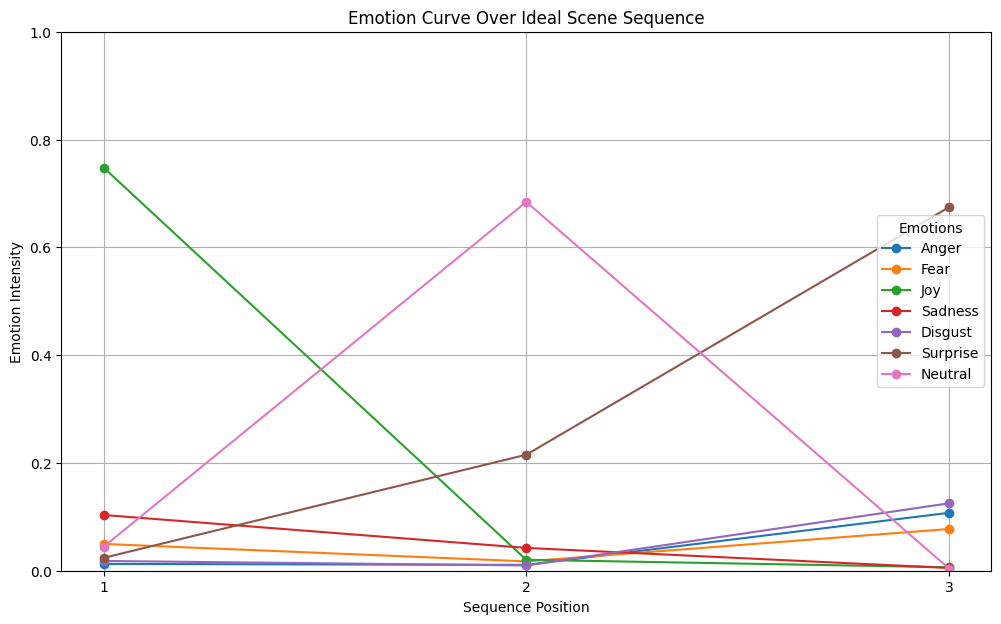

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the ideal scene sequence CSV
csv_file_path = '/content/ideal_scene_sequence.csv'
try:
    df_sequence = pd.read_csv(csv_file_path)
except FileNotFoundError:
    print(f"Error: {csv_file_path} not found.")
    exit()

# Extract sequence position and emotion scores
sequence_positions = df_sequence['sequence_position']
emotion_score_cols = [col for col in df_sequence.columns if col.endswith('_score')]

# Create the plot
plt.figure(figsize=(12, 7))

# Plot each emotion's score over the sequence
for col in emotion_score_cols:
    emotion_name = col.replace('_score', '')
    plt.plot(sequence_positions, df_sequence[col], marker='o', linestyle='-', label=emotion_name.capitalize())

plt.xlabel('Sequence Position')
plt.ylabel('Emotion Intensity')
plt.title('Emotion Curve Over Ideal Scene Sequence')
plt.ylim(0, 1) # Assuming scores are between 0 and 1
plt.xticks(sequence_positions) # Set x-axis ticks to sequence positions
plt.legend(title='Emotions')
plt.grid(True)
plt.show()

## Viewer prediction

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'neutral']

# Function to load and validate emotion data from CSV
def load_emotion_data(csv_file):
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"CSV file not found: {csv_file}")

    df = pd.read_csv(csv_file)
    required_columns = ['video_path', 'emotion'] + [f"{e}_score" for e in emotions]
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        raise KeyError(f"Missing columns: {missing}. Expected: {required_columns}")

    # Validate emotion labels and scores
    for _, row in df.iterrows():
        if row['emotion'].strip().lower() not in emotions:
            raise ValueError(f"Invalid emotion '{row['emotion']}' in CSV. Expected: {emotions}")
        scores = [row[f"{e}_score"] for e in emotions]
        if not (0.99 <= sum(scores) <= 1.01):  # Allow small floating-point errors
            raise ValueError(f"Scores for {row['video_path']} do not sum to ~1: {scores}")

    return df

# Function to predict viewer preferences
def predict_viewer_preferences(df):
    score_cols = [f"{e}_score" for e in emotions]
    max_scores = df[score_cols].max()

    high_arousal = ['anger', 'fear', 'disgust', 'surprise']
    positive_valence = ['joy', 'surprise']

    # Calculate arousal and valence metrics
    arousal_score = sum(max_scores[f"{e}_score"] for e in high_arousal) / len(high_arousal)
    positive_score = sum(max_scores[f"{e}_score"] for e in positive_valence) / len(positive_valence)
    sadness_neutral_score = (max_scores['sadness_score'] + max_scores['neutral_score']) / 2

    preferences = []
    if arousal_score > 0.5:
        preferences.append("High-intensity, attention-grabbing content (e.g., thriller or shock-driven clips).")
    if positive_score > 0.5:
        preferences.append("Uplifting or surprising moments, especially at the climax.")
    if sadness_neutral_score < 0.3:
        preferences.append("Fast-paced, high-energy narrative over reflective or calm moments.")

    # Specific emotion insights
    for emotion in emotions:
        score = max_scores[f"{emotion}_score"]
        if score > 0.6:
            preferences.append(f"Strong {emotion} moments (score: {score:.3f}), suggesting desire for {emotion}-driven experiences.")

    # Narrative arc preference
    preferences.append("A narrative arc with a positive hook, escalating tension, and a surprising or joyful resolution.")

    return preferences

# Function to sequence videos using clustering
def sequence_videos(df):
    df = df.copy()

    # Add dominant emotion score
    df['dominant_score'] = df.apply(lambda row: row[f"{row['emotion']}_score"], axis=1)

    # Extract emotion scores for clustering
    score_cols = [f"{e}_score" for e in emotions]
    X = df[score_cols].values

    # Cluster videos into 3 groups
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    # Define emotional intensity
    high_arousal = ['anger', 'fear', 'disgust', 'surprise']
    low_arousal = ['joy', 'sadness', 'neutral']

    # Calculate cluster centroids
    centroids = kmeans.cluster_centers_
    cluster_arousal = [sum(centroid[emotions.index(e)] for e in high_arousal) for centroid in centroids]

    # Sort clusters: moderate -> high -> low arousal
    cluster_order = np.argsort(cluster_arousal)
    cluster_map = {i: pos for pos, i in enumerate(cluster_order)}

    # Sequence videos
    video_order = []
    used_videos = set()

    for cluster_pos in [cluster_map[i] for i in range(3)]:
        cluster_videos = df[df['cluster'] == cluster_pos]
        for _, row in cluster_videos.sort_values(by='dominant_score', ascending=False).iterrows():
            if row['video_path'] not in used_videos:
                video_order.append(row)
                used_videos.add(row['video_path'])

    # Add remaining videos
    for _, row in df.iterrows():
        if row['video_path'] not in used_videos:
            video_order.append(row)
            used_videos.add(row['video_path'])

    # Create sequenced DataFrame
    sequenced_df = pd.DataFrame(video_order)
    sequenced_df['sequence_position'] = range(1, len(sequenced_df) + 1)

    # Drop temporary columns
    columns = ['sequence_position', 'video_path', 'emotion'] + score_cols
    return sequenced_df[columns]

# Function to create ideal scene sequence CSV with viewer preferences
def create_ideal_scene_sequence(video_dir, input_csv, output_csv):
    # Load and validate input CSV
    df = load_emotion_data(input_csv)

    # Predict viewer preferences
    preferences = predict_viewer_preferences(df)
    print("Predicted Viewer Preferences:")
    for pref in preferences:
        print(f"- {pref}")

    # Verify video files
    for video in df['video_path']:
        if not os.path.exists(os.path.join(video_dir, video)):
            print(f"Warning: Video file not found: {os.path.join(video_dir, video)}")

    # Sequence videos
    sequenced_df = sequence_videos(df)

    # Save to CSV
    sequenced_df.to_csv(output_csv, index=False)
    print(f"\nIdeal scene sequence CSV created: {output_csv}")
    print("\nSequence Preview:")
    print(sequenced_df.round(3))

# Main function
def main():
    video_dir = '/content'
    input_csv = '/content/emotion_data.csv'
    output_csv = '/content/ideal_scene_sequence_viewer_preference.csv'

    try:
        create_ideal_scene_sequence(video_dir, input_csv, output_csv)
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

Predicted Viewer Preferences:
- Uplifting or surprising moments, especially at the climax.
- Strong joy moments (score: 0.748), suggesting desire for joy-driven experiences.
- Strong surprise moments (score: 0.674), suggesting desire for surprise-driven experiences.
- Strong neutral moments (score: 0.684), suggesting desire for neutral-driven experiences.
- A narrative arc with a positive hook, escalating tension, and a surprising or joyful resolution.

Ideal scene sequence CSV created: /content/ideal_scene_sequence_viewer_preference.csv

Sequence Preview:
   sequence_position                                video_path   emotion  \
1                  1  720ca2a6-35ec-4e43-88db-271589ec94ea.mp4       joy   
2                  2  58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4   neutral   
0                  3  09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4  surprise   

   anger_score  fear_score  joy_score  sadness_score  disgust_score  \
1        0.013       0.050      0.748          0.103         

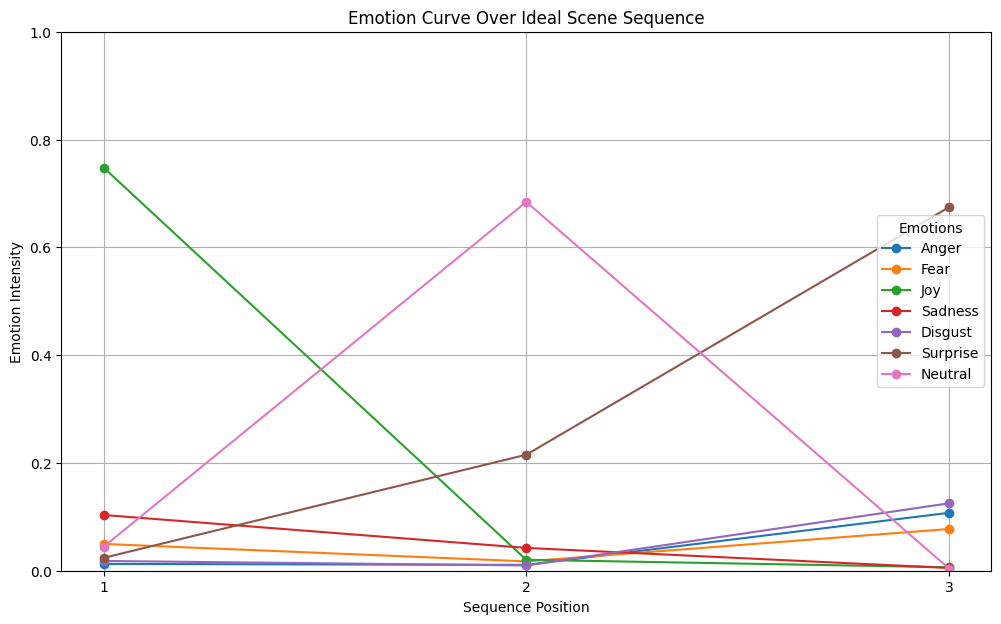

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the ideal scene sequence CSV
csv_file_path = '/content/ideal_scene_sequence_viewer_preference.csv'
try:
    df_sequence = pd.read_csv(csv_file_path)
except FileNotFoundError:
    print(f"Error: {csv_file_path} not found.")
    exit()

# Extract sequence position and emotion scores
sequence_positions = df_sequence['sequence_position']
emotion_score_cols = [col for col in df_sequence.columns if col.endswith('_score')]

# Create the plot
plt.figure(figsize=(12, 7))

# Plot each emotion's score over the sequence
for col in emotion_score_cols:
    emotion_name = col.replace('_score', '')
    plt.plot(sequence_positions, df_sequence[col], marker='o', linestyle='-', label=emotion_name.capitalize())

plt.xlabel('Sequence Position')
plt.ylabel('Emotion Intensity')
plt.title('Emotion Curve Over Ideal Scene Sequence')
plt.ylim(0, 1) # Assuming scores are between 0 and 1
plt.xticks(sequence_positions) # Set x-axis ticks to sequence positions
plt.legend(title='Emotions')
plt.grid(True)
plt.show()

## Selling point

In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'neutral']

# Function to load and validate emotion data from CSV
def load_emotion_data(csv_file):
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"CSV file not found: {csv_file}")

    df = pd.read_csv(csv_file)
    required_columns = ['video_path', 'emotion'] + [f"{e}_score" for e in emotions]
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        raise KeyError(f"Missing columns: {missing}. Expected: {required_columns}")

    # Validate emotion labels and scores
    for _, row in df.iterrows():
        if row['emotion'].strip().lower() not in emotions:
            raise ValueError(f"Invalid emotion '{row['emotion']}' in CSV. Expected: {emotions}")
        scores = [row[f"{e}_score"] for e in emotions]
        if not (0.99 <= sum(scores) <= 1.01):  # Allow small floating-point errors
            raise ValueError(f"Scores for {row['video_path']} do not sum to ~1: {scores}")

    return df

# Function to sequence videos (if sequence CSV is unavailable)
def sequence_videos(df):
    df = df.copy()
    df['dominant_score'] = df.apply(lambda row: row[f"{row['emotion']}_score"], axis=1)
    score_cols = [f"{e}_score" for e in emotions]
    X = df[score_cols].values

    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    high_arousal = ['anger', 'fear', 'disgust', 'surprise']
    centroids = kmeans.cluster_centers_
    cluster_arousal = [sum(centroid[emotions.index(e)] for e in high_arousal) for centroid in centroids]

    cluster_order = np.argsort(cluster_arousal)
    cluster_map = {i: pos for pos, i in enumerate(cluster_order)}

    video_order = []
    used_videos = set()

    for cluster_pos in [cluster_map[i] for i in range(3)]:
        cluster_videos = df[df['cluster'] == cluster_pos]
        for _, row in cluster_videos.sort_values(by='dominant_score', ascending=False).iterrows():
            if row['video_path'] not in used_videos:
                video_order.append(row)
                used_videos.add(row['video_path'])

    for _, row in df.iterrows():
        if row['video_path'] not in used_videos:
            video_order.append(row)
            used_videos.add(row['video_path'])

    sequenced_df = pd.DataFrame(video_order)
    sequenced_df['sequence_position'] = range(1, len(sequenced_df) + 1)
    columns = ['sequence_position', 'video_path', 'emotion'] + score_cols
    return sequenced_df[columns]

# Function to calculate selling points
def calculate_selling_points(df, sequence_df):
    high_arousal = ['anger', 'fear', 'disgust', 'surprise']
    selling_points = []

    for _, row in sequence_df.iterrows():
        video = row['video_path']
        emotion = row['emotion']
        position = row['sequence_position']
        dominant_score = row[f"{emotion}_score"]

        # Calculate selling point score
        arousal_weight = 1.5 if emotion in high_arousal else 1.0
        position_bonus = 0.2 if position == 1 else 0.15 if position in [len(sequence_df)-1, len(sequence_df)] else 0.05
        selling_point_score = (dominant_score * arousal_weight) + position_bonus

        # Define selling point description
        if emotion == 'joy':
            description = f"Uplifting {emotion} moment hooks viewers with positivity and shareability (score: {dominant_score:.3f})."
        elif emotion == 'fear':
            description = f"Intense {emotion} builds suspense, gripping viewers with tension (score: {dominant_score:.3f})."
        elif emotion == 'anger':
            description = f"Fiery {emotion} escalates conflict, driving emotional investment (score: {dominant_score:.3f})."
        elif emotion == 'disgust':
            description = f"Visceral {emotion} shocks viewers, enhancing memorability (score: {dominant_score:.3f})."
        elif emotion == 'surprise':
            description = f"Unexpected {emotion} delivers a thrilling twist, boosting engagement (score: {dominant_score:.3f})."
        else:
            description = f"{emotion.capitalize()} moment supports narrative flow (score: {dominant_score:.3f})."

        # Add narrative role
        if position == 1:
            description += " Ideal for hooking the audience."
        elif position in [len(sequence_df)-1, len(sequence_df)]:
            description += " Perfect for climactic resolution."
        else:
            description += " Builds narrative tension."

        selling_points.append({
            'video_path': video,
            'emotion': emotion,
            'sequence_position': position,
            'selling_point_score': round(selling_point_score, 3),
            'selling_point_description': description
        })

    return pd.DataFrame(selling_points)

# Main function
def main():
    video_dir = '/content'
    input_csv = '/content/emotion_data.csv'
    sequence_csv = '/content/ideal_scene_sequence.csv'
    output_csv = '/content/scene_selling_points.csv'

    try:
        # Load emotion data
        df = load_emotion_data(input_csv)

        # Load or generate sequence
        if os.path.exists(sequence_csv):
            sequence_df = pd.read_csv(sequence_csv)
        else:
            print("Sequence CSV not found. Generating new sequence...")
            sequence_df = sequence_videos(df)
            sequence_df.to_csv(sequence_csv, index=False)
            print(f"Generated sequence CSV: {sequence_csv}")

        # Verify video files
        for video in df['video_path']:
            if not os.path.exists(os.path.join(video_dir, video)):
                print(f"Warning: Video file not found: {os.path.join(video_dir, video)}")

        # Calculate selling points
        selling_points_df = calculate_selling_points(df, sequence_df)

        # Save to CSV
        selling_points_df.to_csv(output_csv, index=False)
        print(f"\nScene selling points CSV created: {output_csv}")
        print("\nSelling Points Preview:")
        print(selling_points_df[['video_path', 'emotion', 'sequence_position', 'selling_point_score', 'selling_point_description']])

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()


Scene selling points CSV created: /content/scene_selling_points.csv

Selling Points Preview:
                                 video_path   emotion  sequence_position  \
0  720ca2a6-35ec-4e43-88db-271589ec94ea.mp4       joy                  1   
1  58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4   neutral                  2   
2  09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4  surprise                  3   

   selling_point_score                          selling_point_description  
0                0.948  Uplifting joy moment hooks viewers with positi...  
1                0.834  Neutral moment supports narrative flow (score:...  
2                1.162  Unexpected surprise delivers a thrilling twist...  


### Using open AI

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from openai import OpenAI
import json

# Emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'neutral']

# Initialize OpenAI client (set API key as environment variable or replace with your key)
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY", "<your_api_key_here>"))

# Function to load and validate emotion data from CSV
def load_emotion_data(csv_file):
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"CSV file not found: {csv_file}")

    df = pd.read_csv(csv_file)
    required_columns = ['video_path', 'emotion'] + [f"{e}_score" for e in emotions]
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        raise KeyError(f"Missing columns: {missing}. Expected: {required_columns}")

    # Validate emotion labels and scores
    for _, row in df.iterrows():
        if row['emotion'].strip().lower() not in emotions:
            raise ValueError(f"Invalid emotion '{row['emotion']}' in CSV. Expected: {emotions}")
        scores = [row[f"{e}_score"] for e in emotions]
        if not (0.99 <= sum(scores) <= 1.01):  # Allow small floating-point errors
            raise ValueError(f"Scores for {row['video_path']} do not sum to ~1: {scores}")

    return df

# Function to sequence videos (if sequence CSV is unavailable)
def sequence_videos(df):
    df = df.copy()
    df['dominant_score'] = df.apply(lambda row: row[f"{row['emotion']}_score"], axis=1)
    score_cols = [f"{e}_score" for e in emotions]
    X = df[score_cols].values

    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    high_arousal = ['anger', 'fear', 'disgust', 'surprise']
    centroids = kmeans.cluster_centers_
    cluster_arousal = [sum(centroid[emotions.index(e)] for e in high_arousal) for centroid in centroids]

    cluster_order = np.argsort(cluster_arousal)
    cluster_map = {i: pos for pos, i in enumerate(cluster_order)}

    video_order = []
    used_videos = set()

    for cluster_pos in [cluster_map[i] for i in range(3)]:
        cluster_videos = df[df['cluster'] == cluster_pos]
        for _, row in cluster_videos.sort_values(by='dominant_score', ascending=False).iterrows():
            if row['video_path'] not in used_videos:
                video_order.append(row)
                used_videos.add(row['video_path'])

    for _, row in df.iterrows():
        if row['video_path'] not in used_videos:
            video_order.append(row)
            used_videos.add(row['video_path'])

    sequenced_df = pd.DataFrame(video_order)
    sequenced_df['sequence_position'] = range(1, len(sequenced_df) + 1)
    columns = ['sequence_position', 'video_path', 'emotion'] + score_cols
    return sequenced_df[columns]

# Function to call OpenAI API for selling point analysis
def get_openai_selling_point(video_path, emotion, scores, position, total_positions):
    prompt = f"""
    You are a video content analyst. Given the emotional profile of a video scene and its position in a sequence, determine its selling point (the most compelling feature for viewer engagement) and suggest a score contribution (0.0 to 0.5) for its emotional appeal. Selling point score should be in between 0 to 1.

    Video: {video_path}
    Dominant Emotion: {emotion}
    Emotion Scores: {', '.join([f'{e}: {s:.3f}' for e, s in scores.items()])}
    Sequence Position: {position} of {total_positions}
    Viewer Preferences: High-intensity, mixed-emotion content with joy/surprise payoff (e.g., thriller or short-form social media).

    Provide a JSON response with:
    - "description": A 1-2 sentence selling point explaining why this scene is compelling.
    - "score_contribution": A float (0.0 to 0.5) based on emotional impact and narrative role.

    Example JSON response:
    ```json
    {{
      "description": "This intense fear scene grips viewers with suspense, building narrative tension.",
      "score_contribution": 0.2
    }}
    ```

    Guidelines:
    - High-arousal emotions (anger, fear, disgust, surprise) grab attention.
    - Joy/surprise enhance shareability and satisfaction.
    - Position 1 is the hook, last positions are climactic, others build tension.
    - Ensure the response is valid JSON.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            response_format={"type": "json_object"}
        )
        result = json.loads(response.choices[0].message.content)
        # Validate response
        if not isinstance(result, dict) or 'description' not in result or 'score_contribution' not in result:
            raise ValueError("Invalid JSON response: missing required fields")
        if not isinstance(result['score_contribution'], (int, float)) or not (0.0 <= result['score_contribution'] <= 0.5):
            raise ValueError("Invalid score_contribution: must be a float between 0.0 and 0.5")
        return result
    except Exception as e:
        print(f"OpenAI API error for {video_path}: {str(e)}")
        # Fallback response
        description = f"{emotion.capitalize()} moment engages viewers with strong emotional impact (score: {scores[emotion]:.3f})."
        if position == 1:
            description += " Ideal for hooking the audience."
        elif position in [total_positions-1, total_positions]:
            description += " Perfect for climactic resolution."
        else:
            description += " Builds narrative tension."
        return {
            "description": description,
            "score_contribution": 0.1
        }

# Function to calculate selling points
def calculate_selling_points(df, sequence_df):
    high_arousal = ['anger', 'fear', 'disgust', 'surprise']
    selling_points = []

    for _, row in sequence_df.iterrows():
        video = row['video_path']
        emotion = row['emotion']
        position = row['sequence_position']
        dominant_score = row[f"{emotion}_score"]

        # Prepare scores for OpenAI
        scores = {e: row[f"{e}_score"] for e in emotions}

        # Get OpenAI analysis
        openai_response = get_openai_selling_point(video, emotion, scores, position, len(sequence_df))
        description = openai_response['description']
        api_score = openai_response['score_contribution']

        # Calculate selling point score
        arousal_weight = 1.5 if emotion in high_arousal else 1.0
        position_bonus = 0.2 if position == 1 else 0.15 if position in [len(sequence_df)-1, len(sequence_df)] else 0.05
        selling_point_score = (dominant_score * arousal_weight) + position_bonus + api_score

        selling_points.append({
            'video_path': video,
            'emotion': emotion,
            'sequence_position': position,
            'selling_point_score': round(selling_point_score, 3),
            'selling_point_description': description
        })

    return pd.DataFrame(selling_points)

# Main function
def main():
    video_dir = '/content'
    input_csv = '/content/emotion_data.csv'
    sequence_csv = '/content/ideal_scene_sequence.csv'
    output_csv = '/content/scene_selling_points.csv'

    try:
        # Load emotion data
        df = load_emotion_data(input_csv)

        # Load or generate sequence
        if os.path.exists(sequence_csv):
            sequence_df = pd.read_csv(sequence_csv)
        else:
            print("Sequence CSV not found. Generating new sequence...")
            sequence_df = sequence_videos(df)
            sequence_df.to_csv(sequence_csv, index=False)
            print(f"Generated sequence CSV: {sequence_csv}")

        # Verify video files
        for video in df['video_path']:
            if not os.path.exists(os.path.join(video_dir, video)):
                print(f"Warning: Video file not found: {os.path.join(video_dir, video)}")

        # Calculate selling points
        selling_points_df = calculate_selling_points(df, sequence_df)

        # Save to CSV
        selling_points_df.to_csv(output_csv, index=False)
        print(f"\nScene selling points CSV created: {output_csv}")
        print("\nSelling Points Preview:")
        print(selling_points_df[['video_path', 'emotion', 'sequence_position', 'selling_point_score', 'selling_point_description']])

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()


Scene selling points CSV created: /content/scene_selling_points.csv

Selling Points Preview:
                                 video_path   emotion  sequence_position  \
0  720ca2a6-35ec-4e43-88db-271589ec94ea.mp4       joy                  1   
1  58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4   neutral                  2   
2  09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4  surprise                  3   

   selling_point_score                          selling_point_description  
0                1.348  The scene radiates joy, immediately captivatin...  
1                1.134  This scene features a notable element of surpr...  
2                1.562  The overwhelming surprise in this climactic sc...  


In [14]:
df = pd.read_csv('/content/scene_selling_points.csv')
df

,video_path,emotion,sequence_position,selling_point_score,selling_point_description
0,720ca2a6-35ec-4e43-88db-271589ec94ea.mp4,joy,1,1.348,"The scene radiates joy, immediately captivatin..."
1,58b718a3-ca12-4193-b109-f11e5bb3aa96.mp4,neutral,2,1.134,This scene features a notable element of surpr...
2,09fdecd0-6365-4f5f-beae-b653c3cbcff3.mp4,surprise,3,1.562,The overwhelming surprise in this climactic sc...


## Compare the results with social media

Collected data for 50 videos.
Market Data Analysis:
              views         likes      comments  engagement_rate   success
count  5.000000e+01  5.000000e+01     50.000000        50.000000  50.00000
mean   1.099183e+07  2.239597e+05   1495.400000         0.025661   0.14000
std    4.101118e+07  6.945412e+05   2590.181193         0.022018   0.35051
min    6.500000e+01  0.000000e+00      0.000000         0.000073   0.00000
25%    4.172180e+05  5.972250e+03    131.750000         0.009382   0.00000
50%    1.620387e+06  1.829900e+04    466.500000         0.021039   0.00000
75%    4.789636e+06  7.449500e+04   2005.750000         0.034097   0.00000
max    2.690455e+08  4.047919e+06  14032.000000         0.107692   1.00000
Average Engagement Rate: 0.0257
Success Ratio (high engagement): 14.00%


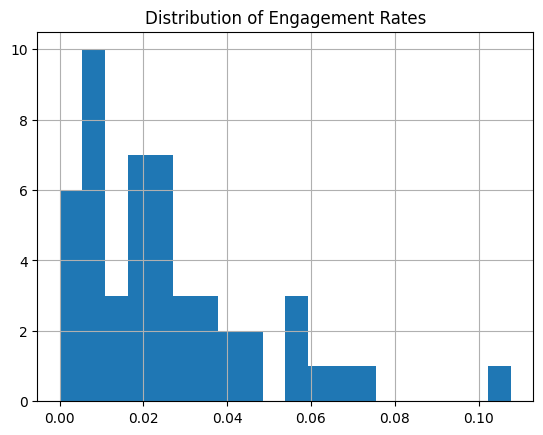

Model Accuracy: 1.00
AUC Score: 1.00
Predicted Success Ratio for New Video: 8.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from googleapiclient.discovery import build  # pip install google-api-python-client
import os

# Step 1: Collect Data from YouTube API (example for similar videos)
def collect_youtube_data(api_key, query, max_results=50):
    youtube = build('youtube', 'v3', developerKey=api_key)
    data = []
    request = youtube.search().list(q=query, part='snippet,id', type='video', maxResults=max_results)
    response = request.execute()

    for item in response['items']:
        video_id = item['id']['videoId']
        stats_request = youtube.videos().list(part='statistics,snippet', id=video_id)
        stats_response = stats_request.execute()

        if stats_response['items']:
            stats = stats_response['items'][0]['statistics']
            views = int(stats.get('viewCount', 0))
            likes = int(stats.get('likeCount', 0))
            comments = int(stats.get('commentCount', 0))
            engagement_rate = (likes + comments) / views if views > 0 else 0

            data.append({
                'video_id': video_id,
                'title': item['snippet']['title'],
                'views': views,
                'likes': likes,
                'comments': comments,
                'engagement_rate': engagement_rate,
                'success': 1 if engagement_rate > 0.05 else 0  # Threshold for "success"
            })

    df = pd.DataFrame(data)
    df.to_csv('similar_videos_data.csv', index=False)
    print(f"Collected data for {len(df)} videos.")
    return df

# Step 2: Analyze Data
def analyze_data(df):
    print("Market Data Analysis:")
    print(df.describe())
    print(f"Average Engagement Rate: {df['engagement_rate'].mean():.4f}")
    print(f"Success Ratio (high engagement): {df['success'].mean():.2%}")

    # Visualize (optional)
    import matplotlib.pyplot as plt
    df['engagement_rate'].hist(bins=20)
    plt.title('Distribution of Engagement Rates')
    plt.savefig('engagement_distribution.png')
    plt.show()

# Step 3: Predict Success Ratio
def predict_success(df):
    # Features: views, likes, comments (add emotion scores if available)
    X = df[['views', 'likes', 'comments']]
    y = df['success']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability (success ratio)

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"Model Accuracy: {accuracy:.2f}")
    print(f"AUC Score: {auc:.2f}")

    # Predict for new video (example)
    new_video = np.array([[10000, 500, 100]])  # Example: 10K views, 500 likes, 100 comments
    success_ratio = model.predict_proba(new_video)[:, 1][0]
    print(f"Predicted Success Ratio for New Video: {success_ratio:.2%}")

    return model

# Main Execution
if __name__ == "__main__":
    # Replace with your YouTube API key
    API_KEY = "<your_youtube_api_key_here>"
    QUERY = "thriller short videos emotional twists"  # Similar to your experiment

    df = collect_youtube_data(API_KEY, QUERY)
    analyze_data(df)
    model = predict_success(df)

### Notebook Summary and Business ROIs

This notebook demonstrates a process for analyzing and sequencing video scenes based on their emotional content, with the goal of creating more engaging and impactful video narratives, particularly relevant for short-form content like social media.

The key steps covered include:

1.  **Emotion Data Generation/Loading:** Creating or loading a dataset that associates video clips with their dominant emotions and detailed emotion scores (e.g., anger, joy, fear, etc.). While dummy data is used here, this would typically involve facial landmark detection (as shown in earlier attempts) or other emotion recognition techniques.
2.  **Average Emotion Analysis:** Visualizing the average emotional profile of the video collection to understand the overall emotional landscape of the content.
3.  **Video Sequencing:** Implementing logic to sequence videos based on emotional flow, aiming for a compelling narrative arc. This notebook explored two methods: a predefined narrative arc order and a clustering-based approach.
4.  **Improvement Suggestions & Key Scenes:** Generating specific editing suggestions and identifying key moments within videos based on their dominant emotions and position in the sequence to enhance emotional impact.
5.  **Emotion Curve Visualization:** Plotting the emotional intensity over the sequenced videos to visually assess the emotional journey of the viewer.
6.  **Viewer Preference Prediction:** Analyzing the emotional profile of the content to infer potential viewer preferences for similar content types (e.g., preference for high-arousal or positive content).
7.  **Scene Selling Point Calculation:** Identifying the most compelling scenes for viewer engagement based on their emotional intensity, narrative position, and inferred viewer preferences, potentially utilizing external APIs like OpenAI for nuanced analysis.
8.  **Comparison with Social Media Data (Attempted):** Exploring how to compare the emotional analysis and predicted selling points with real-world social media engagement data (e.g., YouTube views, likes, comments) to validate the approach and refine predictions.

**Business ROIs (Return on Investment):**

Implementing these techniques can lead to significant business benefits, especially for content creators, marketers, and media companies:

1.  **Increased Viewer Engagement:** By sequencing scenes for optimal emotional flow and highlighting key selling points, videos are more likely to capture and retain viewer attention, leading to higher watch times, likes, shares, and comments.
2.  **Improved Content Performance:** More engaging content generally performs better on social media platforms and other distribution channels, leading to increased visibility and organic reach.
3.  **Higher Conversion Rates:** For marketing or promotional videos, a well-sequenced emotional narrative can be more persuasive and drive higher conversion rates for calls to action.
4.  **Reduced Content Creation Costs (Potentially):** By identifying the most impactful scenes and suggesting specific improvements, creators can streamline the editing process and focus efforts on elements that matter most for engagement.
5.  **Data-Driven Content Strategy:** The analysis provides valuable insights into what emotional content resonates with the target audience, informing future content creation decisions and strategy.
6.  **Enhanced Brand Storytelling:** Emotionally resonant videos create a stronger connection with the audience and can effectively communicate brand values and messages.
7.  **Competitive Advantage:** Utilizing data-driven emotional analysis for video production can provide a competitive edge in a crowded content landscape.

In essence, this notebook provides a framework for moving beyond intuition in video editing and sequencing, using data and analysis to create content that is more likely to emotionally connect with viewers and achieve business objectives.